In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

def get_weather_data(api_key, city):
    url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {"q": city,"appid": api_key,"units": "metric"}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Errror fetching data: {response.status_code}")

In [11]:
def parse_weather_data(weather_data):
    df = pd.json_normalize(weather_data, record_path=['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    df.set_index('dt', inplace=True)
    df = df[['main.temp_max']]
    df.columns = ['Temp_max']
    return df

API_KEY = 'd8803f8ccf5e51834e1bfa194c36618f'
CITY = 'Bandung'

weather_data = get_weather_data(API_KEY, CITY)

data = parse_weather_data(weather_data)

data['Hour'] = data.index.hour
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month

X = data[['Hour', 'Day', 'Month']]
y = data['Temp_max']

In [ ]:
import requests

API_KEY = 'd8803f8ccf5e51834e1bfa194c36618f'
CITY = 'Bandung'

def get_weather_data(api_key, city):
    url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {"q": city, "appid": api_key, "units": "metric"}
    response = requests.get(url, params=params)  # pastikan menggunakan 'requests'
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.text)  # Menampilkan pesan kesalahan

# Ambil data cuaca untuk Bandung
weather_data = get_weather_data(API_KEY, CITY)

# Menampilkan data cuaca
print(weather_data)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {'objective': 'reg:squarederror', 'colsample_bytree' : 0.3,'learning_rate':0.1, 'max_depth': 5, 'alpha':10}

In [13]:
model = xgb.train(params, dtrain, num_boost_round=100)

y_pred = model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 3.76


In [17]:
# Menghitung future_hours dengan benar
future_hours = np.array([
    [i % 24, (i // 24) % 7, (i // 24) % 12 + 1]  # Memastikan bahwa setiap elemen dalam array dibuat dalam sebuah list
    for i in range(len(data), len(data) + 7 * 24)
])

# Membuat DataFrame dari future_hours
future_df = pd.DataFrame(future_hours, columns=['Hour', 'Day', 'Month'])

# Membuat DMatrix untuk prediksi
future_dmatrix = xgb.DMatrix(future_df)

# Mendapatkan prediksi
future_predictions = model.predict(future_dmatrix)

# Menghasilkan tanggal untuk prediksi
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(hours=1), periods=7 * 24, freq='H')

# Membuat DataFrame untuk prediksi temperatur maksimum
forecast_df = pd.DataFrame({'Forecast_Temp_Max': future_predictions}, index=future_dates)

# Menampilkan DataFrame prediksi
print(forecast_df)


                     Forecast_Temp_Max
2024-10-14 07:00:00          22.632313
2024-10-14 08:00:00          22.632313
2024-10-14 09:00:00          22.632313
2024-10-14 10:00:00          22.632313
2024-10-14 11:00:00          22.632313
...                                ...
2024-10-21 02:00:00          28.238035
2024-10-21 03:00:00          23.822746
2024-10-21 04:00:00          23.822746
2024-10-21 05:00:00          23.822746
2024-10-21 06:00:00          22.632313

[168 rows x 1 columns]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5968\4054495456.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(hours=1), periods=7 * 24, freq='H')


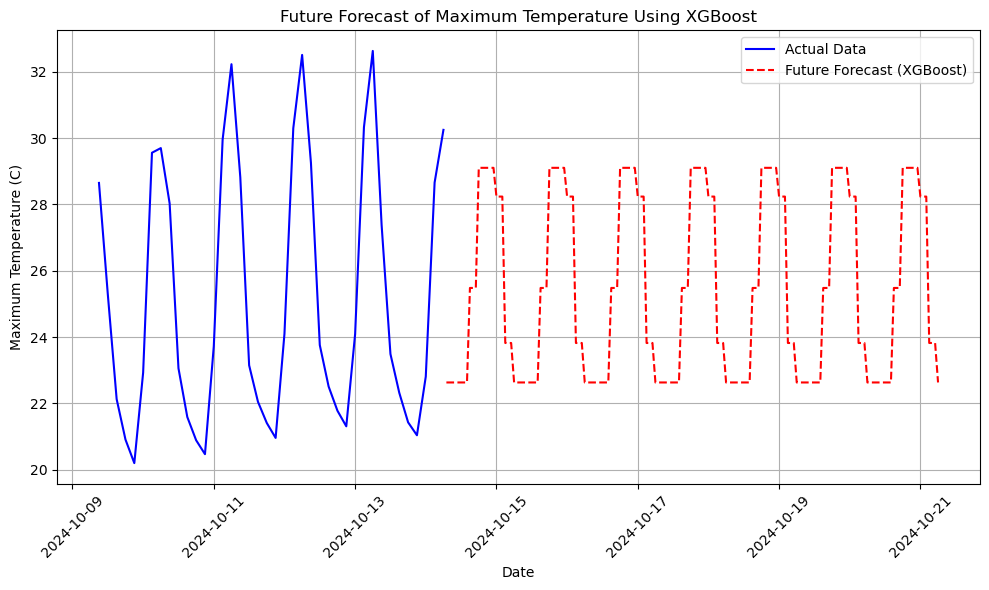

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(data['Temp_max'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Future Forecast (XGBoost)', color='red', linestyle='--')
plt.title('Future Forecast of Maximum Temperature Using XGBoost')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()